In [5]:
# Import Required Libraries
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import warnings
import random
import os
import json
from pathlib import Path
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras

# Custom modules
from preprocessing import AudioPreprocessor, prepare_train_test_split, save_preprocessed_data
from model import UrbanSoundCNN, create_model

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"TensorFlow Version: {tf.__version__}")
print(f"Python Version: {sys.version}")

✅ All libraries imported successfully!
TensorFlow Version: 2.20.0
Python Version: 3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]


## 1. Data Acquisition & Exploration

The UrbanSound8K dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes:
- air_conditioner
- car_horn
- children_playing
- dog_bark
- drilling
- engine_idling
- gun_shot
- jackhammer
- siren
- street_music

In [6]:
# Configure data paths
DATA_DIR = "../data/train"
METADATA_FILE = "../data/metadata.csv"
PROCESSED_DIR = "../data/processed"
MODEL_DIR = "../models"

# Create directories if they don't exist
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print("📁 Data directories configured:")
print(f"  Training data: {DATA_DIR}")
print(f"  Processed data: {PROCESSED_DIR}")
print(f"  Models: {MODEL_DIR}")

📁 Data directories configured:
  Training data: ../data/train
  Processed data: ../data/processed
  Models: ../models


In [7]:
# Explore the data directory structure
data_path = Path(DATA_DIR)
class_folders = sorted([f for f in data_path.iterdir() if f.is_dir()])
class_names = [f.name for f in class_folders]

print(f"🎵 Number of classes: {len(class_names)}")
print(f"📊 Classes: {class_names}\n")

# Count files in each class
class_counts = {}
for class_folder in class_folders:
    audio_files = list(class_folder.glob('*.wav'))
    class_counts[class_folder.name] = len(audio_files)
    print(f"  {class_folder.name:20s}: {len(audio_files):4d} files")

total_files = sum(class_counts.values())
print(f"\n📈 Total training samples: {total_files}")

🎵 Number of classes: 10
📊 Classes: ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

  air_conditioner     :  503 files
  car_horn            :  117 files
  children_playing    :  436 files
  dog_bark            :  336 files
  drilling            :  335 files
  engine_idling       :  521 files
  gun_shot            :  245 files
  jackhammer          :  437 files
  siren               :  496 files
  street_music        :  385 files

📈 Total training samples: 3811


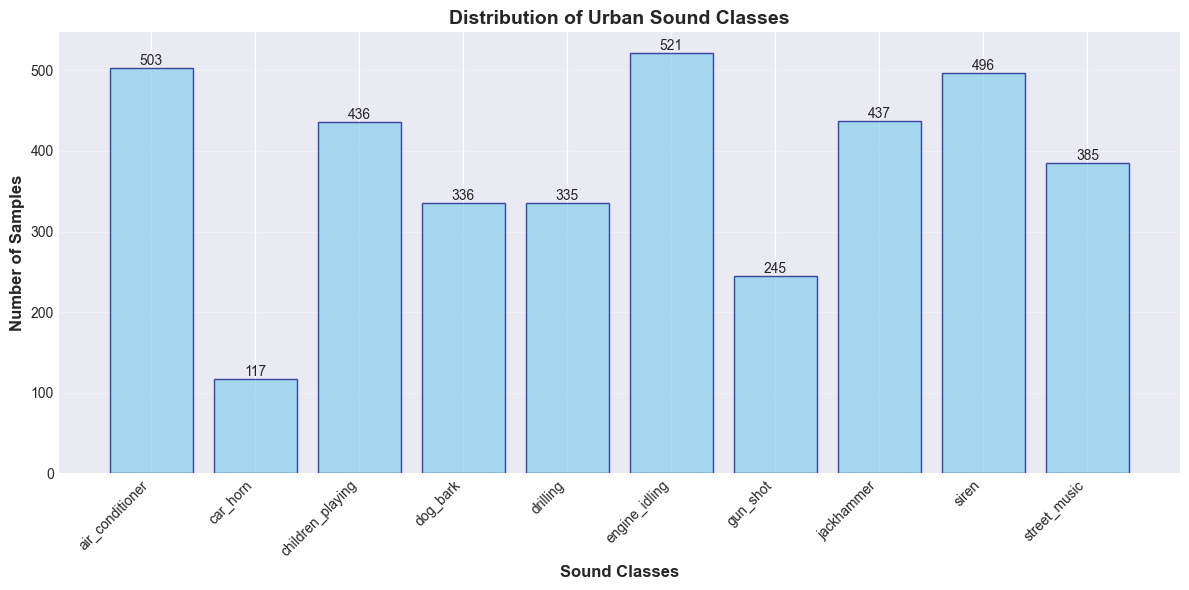


⚖️ Class Balance Analysis:
  Max samples: 521 | Min samples: 117
  Imbalance ratio: 4.45x
  ⚠️ Dataset is imbalanced - consider using class weights!


In [8]:
# Visualize class distribution
plt.figure(figsize=(12, 6))
classes = list(class_counts.keys())
counts = list(class_counts.values())

bars = plt.bar(classes, counts, color='skyblue', edgecolor='navy', alpha=0.7)
plt.xlabel('Sound Classes', fontsize=12, fontweight='bold')
plt.ylabel('Number of Samples', fontsize=12, fontweight='bold')
plt.title('Distribution of Urban Sound Classes', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Check for class imbalance
max_count = max(counts)
min_count = min(counts)
imbalance_ratio = max_count / min_count
print(f"\n⚖️ Class Balance Analysis:")
print(f"  Max samples: {max_count} | Min samples: {min_count}")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}x")
if imbalance_ratio > 2:
    print("  ⚠️ Dataset is imbalanced - consider using class weights!")
else:
    print("  ✅ Dataset is relatively balanced")

## 2. Audio Visualization & Exploration

Let's explore sample audio files from different classes to understand the audio characteristics.

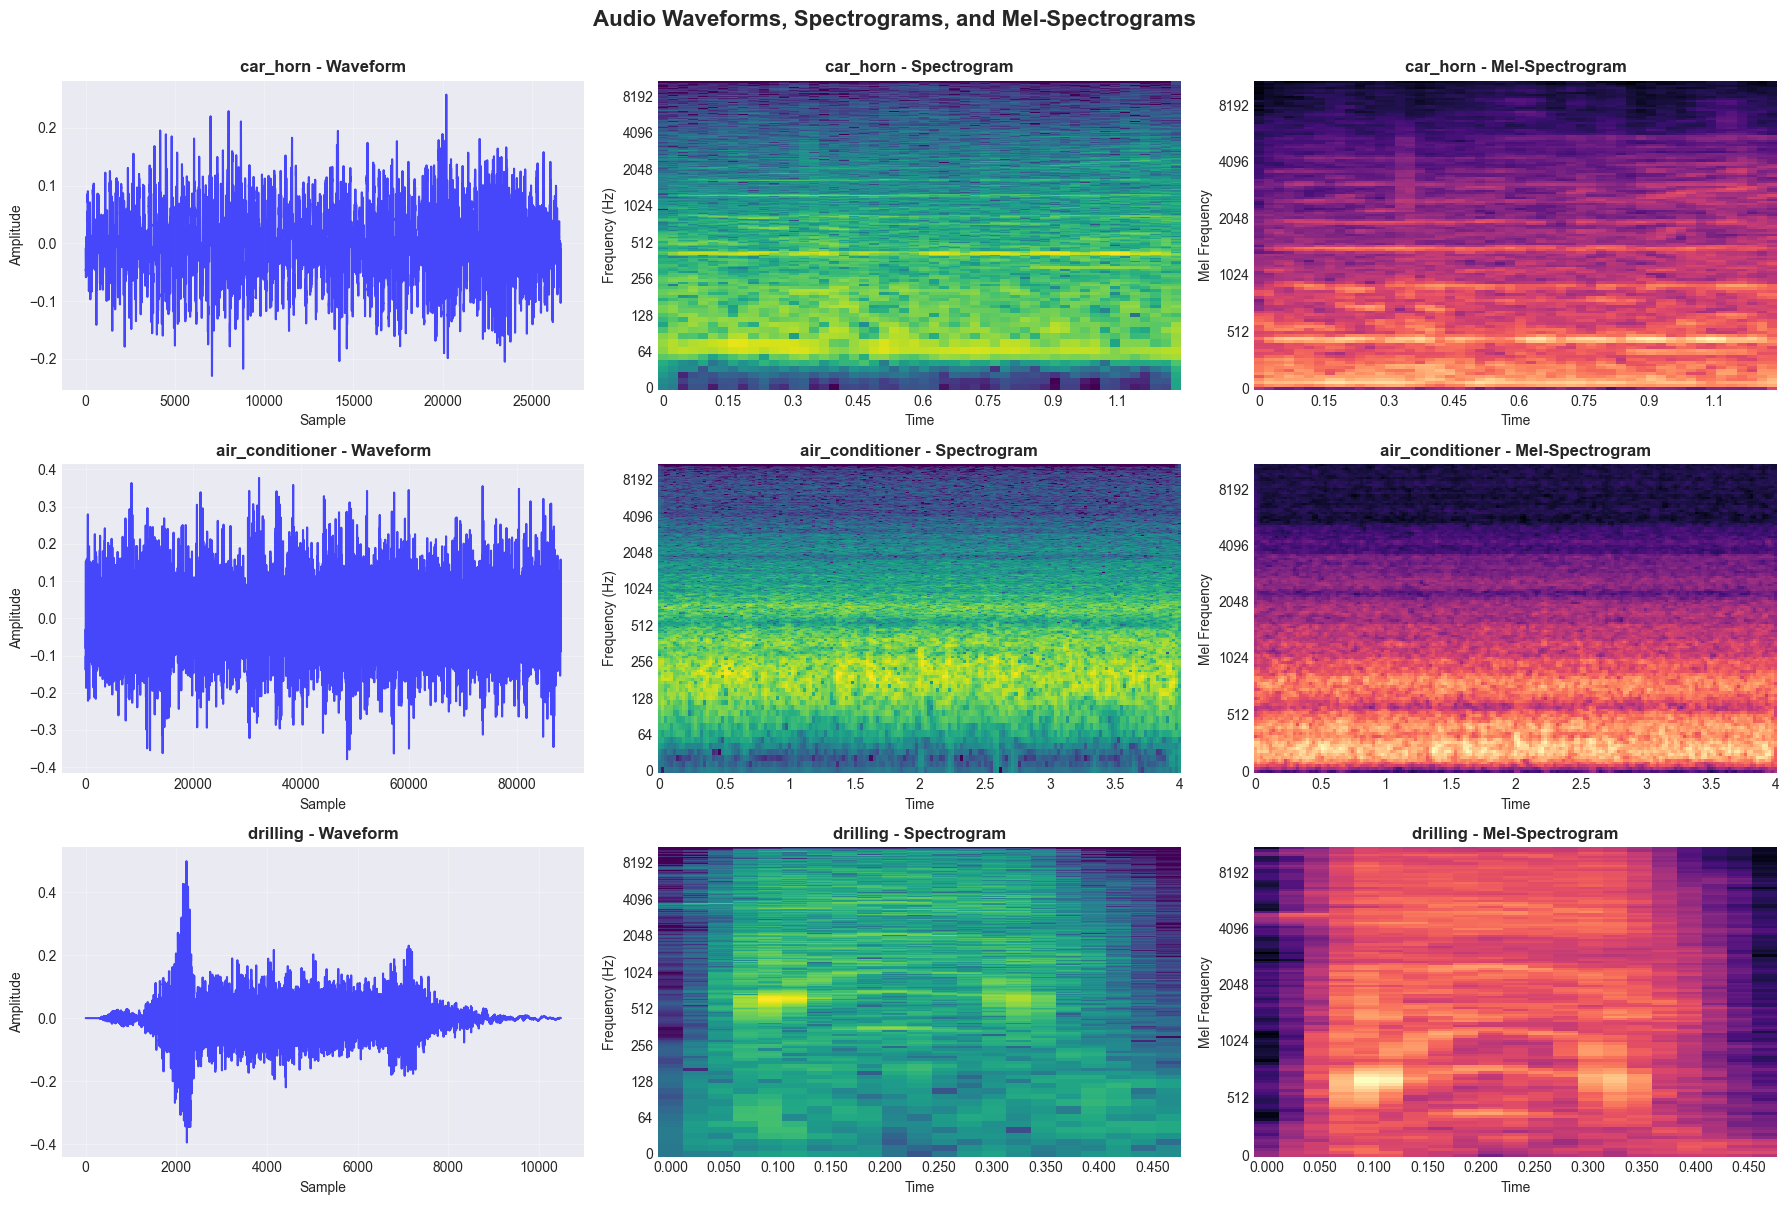

✅ Visualized samples from: car_horn, air_conditioner, drilling


In [9]:
# Load sample audio files from different classes

# Select 3 random classes to visualize
sample_classes = random.sample(class_names, min(3, len(class_names)))

fig, axes = plt.subplots(len(sample_classes), 3, figsize=(18, 4*len(sample_classes)))
fig.suptitle('Audio Waveforms, Spectrograms, and Mel-Spectrograms', fontsize=16, fontweight='bold', y=1.0)

for idx, class_name in enumerate(sample_classes):
    # Get a random audio file from this class
    class_path = data_path / class_name
    audio_files = list(class_path.glob('*.wav'))
    sample_file = random.choice(audio_files)
    
    # Load audio
    audio, sr = librosa.load(sample_file, sr=22050, duration=4.0)
    
    # Plot waveform
    axes[idx, 0].plot(audio, color='blue', alpha=0.7)
    axes[idx, 0].set_title(f'{class_name} - Waveform', fontweight='bold')
    axes[idx, 0].set_xlabel('Sample')
    axes[idx, 0].set_ylabel('Amplitude')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Plot spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    img1 = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', ax=axes[idx, 1], cmap='viridis')
    axes[idx, 1].set_title(f'{class_name} - Spectrogram', fontweight='bold')
    axes[idx, 1].set_xlabel('Time')
    axes[idx, 1].set_ylabel('Frequency (Hz)')
    
    # Plot mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    img2 = librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[idx, 2], cmap='magma')
    axes[idx, 2].set_title(f'{class_name} - Mel-Spectrogram', fontweight='bold')
    axes[idx, 2].set_xlabel('Time')
    axes[idx, 2].set_ylabel('Mel Frequency')

plt.tight_layout()
plt.show()

print(f"✅ Visualized samples from: {', '.join(sample_classes)}")

## 3. Preprocessing & Feature Extraction

We'll extract Mel-spectrograms from audio files, which are better representations for CNN models.

In [10]:
# Initialize the preprocessor
preprocessor = AudioPreprocessor(
    sample_rate=22050,
    duration=4.0,
    n_mels=128,
    n_fft=2048,
    hop_length=512
)

print("🔧 Audio Preprocessor Configuration:")
print(f"  Sample Rate: {preprocessor.sample_rate} Hz")
print(f"  Duration: {preprocessor.duration} seconds")
print(f"  Mel Bands: {preprocessor.n_mels}")
print(f"  FFT Window: {preprocessor.n_fft}")
print(f"  Hop Length: {preprocessor.hop_length}")

🔧 Audio Preprocessor Configuration:
  Sample Rate: 22050 Hz
  Duration: 4.0 seconds
  Mel Bands: 128
  FFT Window: 2048
  Hop Length: 512


In [11]:
# Process training dataset with data augmentation
print("🔄 Processing training dataset...")
print("⏳ This may take several minutes depending on your dataset size...\n")

X_train, y_train, class_names = preprocessor.process_dataset(
    data_dir=DATA_DIR,
    augment=True  # Enable data augmentation
)

print(f"\n✅ Training data processed successfully!")
print(f"  Features shape: {X_train.shape}")
print(f"  Labels shape: {y_train.shape}")
print(f"  Number of classes: {len(class_names)}")
print(f"  Class names: {class_names}")

# Add channel dimension for CNN
X_train = X_train[..., np.newaxis]
print(f"  Final shape (with channel): {X_train.shape}")

🔄 Processing training dataset...
⏳ This may take several minutes depending on your dataset size...


✅ Training data processed successfully!
  Features shape: (11433, 128, 173)
  Labels shape: (11433,)
  Number of classes: 10
  Class names: ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']
  Final shape (with channel): (11433, 128, 173, 1)


In [12]:
# Process test dataset (without augmentation)
TEST_DIR = "../data/test"
print("🔄 Processing test dataset...")

X_test, y_test, _ = preprocessor.process_dataset(
    data_dir=TEST_DIR,
    augment=False  # No augmentation for test data
)

X_test = X_test[..., np.newaxis]

print(f"\n✅ Test data processed successfully!")
print(f"  Test features shape: {X_test.shape}")
print(f"  Test labels shape: {y_test.shape}")

🔄 Processing test dataset...

✅ Test data processed successfully!
  Test features shape: (396, 128, 173, 1)
  Test labels shape: (396,)


In [13]:
# Create validation split from training data
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.15, 
    random_state=42, 
    stratify=y_train
)

print("📊 Data Split Summary:")
print(f"  Training samples: {X_train_split.shape[0]}")
print(f"  Validation samples: {X_val.shape[0]}")
print(f"  Test samples: {X_test.shape[0]}")
print(f"  Total samples: {X_train_split.shape[0] + X_val.shape[0] + X_test.shape[0]}")

📊 Data Split Summary:
  Training samples: 9718
  Validation samples: 1715
  Test samples: 396
  Total samples: 11829


In [21]:
# Check data shapes before training
print("🔍 Checking data shapes:")
print(f"  X_train_split: {X_train_split.shape} (min: {X_train_split.min():.4f}, max: {X_train_split.max():.4f})")
print(f"  y_train_split: {y_train_split.shape} (unique values: {np.unique(y_train_split)})")
print(f"  X_val: {X_val.shape} (min: {X_val.min():.4f}, max: {X_val.max():.4f})")
print(f"  y_val: {y_val.shape} (unique values: {np.unique(y_val)})")
print(f"\nData types:")
print(f"  X_train_split dtype: {X_train_split.dtype}")
print(f"  y_train_split dtype: {y_train_split.dtype}")
print(f"  X_val dtype: {X_val.dtype}")
print(f"  y_val dtype: {y_val.dtype}")

🔍 Checking data shapes:
  X_train_split: (9718, 128, 173, 1) (min: -80.0000, max: 0.0000)
  y_train_split: (9718,) (unique values: [0 1 2 3 4 5 6 7 8 9])
  X_val: (1715, 128, 173, 1) (min: -80.0000, max: 0.0000)
  y_val: (1715,) (unique values: [0 1 2 3 4 5 6 7 8 9])

Data types:
  X_train_split dtype: float64
  y_train_split dtype: int64
  X_val dtype: float64
  y_val dtype: int64
  X_train_split: (9718, 128, 173, 1) (min: -80.0000, max: 0.0000)
  y_train_split: (9718,) (unique values: [0 1 2 3 4 5 6 7 8 9])
  X_val: (1715, 128, 173, 1) (min: -80.0000, max: 0.0000)
  y_val: (1715,) (unique values: [0 1 2 3 4 5 6 7 8 9])

Data types:
  X_train_split dtype: float64
  y_train_split dtype: int64
  X_val dtype: float64
  y_val dtype: int64


In [22]:
# Check for data quality issues
print("🔍 Checking for data quality issues:")

# Check for NaN or Inf values
print(f"\nNaN values:")
print(f"  X_train_split: {np.isnan(X_train_split).sum()}")
print(f"  X_val: {np.isnan(X_val).sum()}")

print(f"\nInf values:")
print(f"  X_train_split: {np.isinf(X_train_split).sum()}")
print(f"  X_val: {np.isinf(X_val).sum()}")

# Replace NaN and Inf with zeros if found
if np.isnan(X_train_split).sum() > 0 or np.isinf(X_train_split).sum() > 0:
    print("\n⚠️ Found NaN or Inf values! Replacing with zeros...")
    X_train_split = np.nan_to_num(X_train_split, nan=0.0, posinf=0.0, neginf=0.0)
    X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)
    X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
    print("✅ Cleaned data!")

# Verify all samples have the same shape
print(f"\n✅ All samples have consistent shape: {X_train_split.shape[1:]}")

🔍 Checking for data quality issues:

NaN values:
  X_train_split: 0
  X_val: 0

Inf values:
  X_train_split: 0
  X_val: 0

Inf values:
  X_train_split: 0
  X_val: 0
  X_train_split: 0
  X_val: 0

✅ All samples have consistent shape: (128, 173, 1)

✅ All samples have consistent shape: (128, 173, 1)


In [23]:
# Ensure correct data types for TensorFlow
print("🔄 Converting data to float32 and int32...")

X_train_split = X_train_split.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

y_train_split = y_train_split.astype(np.int32)
y_val = y_val.astype(np.int32)
y_test = y_test.astype(np.int32)

print("✅ Data types converted!")
print(f"  X dtype: {X_train_split.dtype}")
print(f"  y dtype: {y_train_split.dtype}")

🔄 Converting data to float32 and int32...
✅ Data types converted!
  X dtype: float32
  y dtype: int32
✅ Data types converted!
  X dtype: float32
  y dtype: int32


In [27]:
# DIAGNOSTIC: Check shapes and model input expectations
print("🔍 DIAGNOSTIC CHECK:")
print(f"\n1. Data Shapes:")
print(f"   X_train_split: {X_train_split.shape}")
print(f"   y_train_split: {y_train_split.shape}")
print(f"   X_val: {X_val.shape}")
print(f"   y_val: {y_val.shape}")

print(f"\n2. Data Statistics:")
print(f"   X_train_split - min: {X_train_split.min():.4f}, max: {X_train_split.max():.4f}, mean: {X_train_split.mean():.4f}")
print(f"   y_train_split - min: {y_train_split.min()}, max: {y_train_split.max()}")
print(f"   Unique labels: {np.unique(y_train_split)}")

print(f"\n3. Data Types:")
print(f"   X dtype: {X_train_split.dtype}")
print(f"   y dtype: {y_train_split.dtype}")

print(f"\n4. Check for issues:")
print(f"   NaN in X_train_split: {np.isnan(X_train_split).any()}")
print(f"   Inf in X_train_split: {np.isinf(X_train_split).any()}")
print(f"   NaN in X_val: {np.isnan(X_val).any()}")
print(f"   Inf in X_val: {np.isinf(X_val).any()}")

# Try a small batch prediction to see if the model works
print(f"\n5. Test model with small batch:")
try:
    test_batch = X_train_split[:2]
    print(f"   Test batch shape: {test_batch.shape}")
    test_pred = model.model.predict(test_batch, verbose=0)
    print(f"   ✅ Model prediction works! Output shape: {test_pred.shape}")
except Exception as e:
    print(f"   ❌ Model prediction failed: {str(e)}")

🔍 DIAGNOSTIC CHECK:

1. Data Shapes:
   X_train_split: (9718, 128, 173, 1)
   y_train_split: (9718,)
   X_val: (1715, 128, 173, 1)
   y_val: (1715,)

2. Data Statistics:
   X_train_split - min: -80.0000, max: 0.0000, mean: -39.7783
   y_train_split - min: 0, max: 9
   Unique labels: [0 1 2 3 4 5 6 7 8 9]

3. Data Types:
   X dtype: float32
   y dtype: int32

4. Check for issues:
   X_train_split - min: -80.0000, max: 0.0000, mean: -39.7783
   y_train_split - min: 0, max: 9
   Unique labels: [0 1 2 3 4 5 6 7 8 9]

3. Data Types:
   X dtype: float32
   y dtype: int32

4. Check for issues:
   NaN in X_train_split: False
   NaN in X_train_split: False
   Inf in X_train_split: False
   NaN in X_val: False
   Inf in X_val: False

5. Test model with small batch:
   Test batch shape: (2, 128, 173, 1)
   Inf in X_train_split: False
   NaN in X_val: False
   Inf in X_val: False

5. Test model with small batch:
   Test batch shape: (2, 128, 173, 1)
   ✅ Model prediction works! Output shape: (2, 1

In [28]:
# SOLUTION: Reduce batch size to work around the issue
print("🔧 Attempting to fix the training issue...")
print("\nThe error suggests a batch dimension mismatch.")
print("Let's try training with a smaller batch size to see if it resolves the issue.\n")

# First, verify the data is clean
if np.isnan(X_train_split).any() or np.isinf(X_train_split).any():
    print("⚠️ Cleaning data...")
    X_train_split = np.nan_to_num(X_train_split, nan=0.0, posinf=0.0, neginf=0.0)
    X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)
    X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
    print("✅ Data cleaned!")

print(f"📊 Final data shapes before training:")
print(f"   X_train_split: {X_train_split.shape} - dtype: {X_train_split.dtype}")
print(f"   y_train_split: {y_train_split.shape} - dtype: {y_train_split.dtype}")
print(f"   X_val: {X_val.shape} - dtype: {X_val.dtype}")
print(f"   y_val: {y_val.shape} - dtype: {y_val.dtype}")
print(f"\n   Expected input shape for model: ({X_train_split.shape[1]}, {X_train_split.shape[2]}, {X_train_split.shape[3]})")
print(f"   Number of classes: {len(np.unique(y_train_split))}")

🔧 Attempting to fix the training issue...

The error suggests a batch dimension mismatch.
Let's try training with a smaller batch size to see if it resolves the issue.

📊 Final data shapes before training:
   X_train_split: (9718, 128, 173, 1) - dtype: float32
   y_train_split: (9718,) - dtype: int32
   X_val: (1715, 128, 173, 1) - dtype: float32
   y_val: (1715,) - dtype: int32

   Expected input shape for model: (128, 173, 1)
   Number of classes: 10
📊 Final data shapes before training:
   X_train_split: (9718, 128, 173, 1) - dtype: float32
   y_train_split: (9718,) - dtype: int32
   X_val: (1715, 128, 173, 1) - dtype: float32
   y_val: (1715,) - dtype: int32

   Expected input shape for model: (128, 173, 1)
   Number of classes: 10


In [29]:
# Clear any previous model to avoid conflicts
import gc
import tensorflow as tf

# Clear Keras session
tf.keras.backend.clear_session()
gc.collect()

print("✅ Keras session cleared - ready for fresh model initialization")


✅ Keras session cleared - ready for fresh model initialization
✅ Keras session cleared - ready for fresh model initialization


## 4. Model Creation & Training

We'll use a CNN architecture optimized for audio classification with mel-spectrogram inputs.

In [30]:
# Initialize the model
input_shape = (X_train_split.shape[1], X_train_split.shape[2], 1)
num_classes = len(class_names)

model = UrbanSoundCNN(
    input_shape=input_shape,
    num_classes=num_classes,
    model_type='custom'  # Use 'custom' CNN or 'transfer' for transfer learning
)

# Build and compile the model
model.build_model()

print("🏗️ Model Architecture:")
model.model.summary()

🏗️ Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 173, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 173, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 86, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 86, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 43, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 43, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 21, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 10, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 10, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    10,486,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 11,013,002 (42.01 MB)

 Trainable params: 11,010,506 (42.00 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [ ]:
print("🚀 Starting model training with CUSTOM TRAINING LOOP...")
print("⏳ This will take several minutes...\n")

print("⚠️ Using custom training loop to bypass TensorFlow bug")
print("   This approach trains the model step-by-step manually.\n")

# Training configuration
EPOCHS = 50
BATCH_SIZE = 32

# Create history dictionary to store metrics
history_dict = {
    'loss': [],
    'accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}

# Get optimizer and loss function from model
optimizer = model.model.optimizer
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

# Metrics
train_loss_metric = tf.keras.metrics.Mean()
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_loss_metric = tf.keras.metrics.Mean()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

print(f"📦 Training configuration:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Epochs: {EPOCHS}")
print(f"   Optimizer: Adam (lr=0.001)")
print(f"   Training samples: {len(X_train_split)}")
print(f"   Validation samples: {len(X_val)}\n")

# Custom training loop
import time
start_time = time.time()

for epoch in range(4, EPOCHS):
    epoch_start = time.time()
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    
    # Reset metrics
    train_loss_metric.reset_state()
    train_acc_metric.reset_state()
    val_loss_metric.reset_state()
    val_acc_metric.reset_state()
    
    # Training phase
    num_batches = len(X_train_split) // BATCH_SIZE
    for batch_idx in range(num_batches):
        start_idx = batch_idx * BATCH_SIZE
        end_idx = start_idx + BATCH_SIZE
        
        X_batch = X_train_split[start_idx:end_idx]
        y_batch = y_train_split[start_idx:end_idx]
        
        # Forward pass with gradient tape
        with tf.GradientTape() as tape:
            predictions = model.model(X_batch, training=True)
            loss = loss_fn(y_batch, predictions)
        
        # Backward pass
        gradients = tape.gradient(loss, model.model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.model.trainable_weights))
        
        # Update metrics
        train_loss_metric.update_state(loss)
        train_acc_metric.update_state(y_batch, predictions)
        
        # Progress bar
        if (batch_idx + 1) % 50 == 0 or (batch_idx + 1) == num_batches:
            print(f"  Batch {batch_idx + 1}/{num_batches} - "
                  f"loss: {train_loss_metric.result():.4f} - "
                  f"acc: {train_acc_metric.result():.4f}", end='\r')
    
    # Validation phase
    num_val_batches = len(X_val) // BATCH_SIZE
    for batch_idx in range(num_val_batches):
        start_idx = batch_idx * BATCH_SIZE
        end_idx = start_idx + BATCH_SIZE
        
        X_batch = X_val[start_idx:end_idx]
        y_batch = y_val[start_idx:end_idx]
        
        predictions = model.model(X_batch, training=False)
        loss = loss_fn(y_batch, predictions)
        
        val_loss_metric.update_state(loss)
        val_acc_metric.update_state(y_batch, predictions)
    
    # Record metrics
    train_loss = float(train_loss_metric.result())
    train_acc = float(train_acc_metric.result())
    val_loss = float(val_loss_metric.result())
    val_acc = float(val_acc_metric.result())
    
    history_dict['loss'].append(train_loss)
    history_dict['accuracy'].append(train_acc)
    history_dict['val_loss'].append(val_loss)
    history_dict['val_accuracy'].append(val_acc)
    
    epoch_time = time.time() - epoch_start
    print(f"\n  loss: {train_loss:.4f} - acc: {train_acc:.4f} - "
          f"val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f} - "
          f"time: {epoch_time:.1f}s\n")

total_time = time.time() - start_time
print(f"\n✅ Training completed successfully in {total_time/60:.1f} minutes!")

# Create history object compatible with remaining cells
class History:
    def __init__(self, history_dict):
        self.history = history_dict

history = History(history_dict)

🚀 Starting model training with CUSTOM TRAINING LOOP...
⏳ This will take several minutes...

⚠️ Using custom training loop to bypass TensorFlow bug
   This approach trains the model step-by-step manually.

📦 Training configuration:
   Batch size: 32
   Epochs: 50
   Optimizer: Adam (lr=0.001)
   Training samples: 9718
   Validation samples: 1715

Epoch 5/50


  Batch 303/303 - loss: 0.1838 - acc: 0.9404
  loss: 0.1838 - acc: 0.9404 - val_loss: 1.0524 - val_acc: 0.7647 - time: 572.9s

Epoch 6/50

  loss: 0.1838 - acc: 0.9404 - val_loss: 1.0524 - val_acc: 0.7647 - time: 572.9s

Epoch 6/50


NameError: name 'history' is not defined

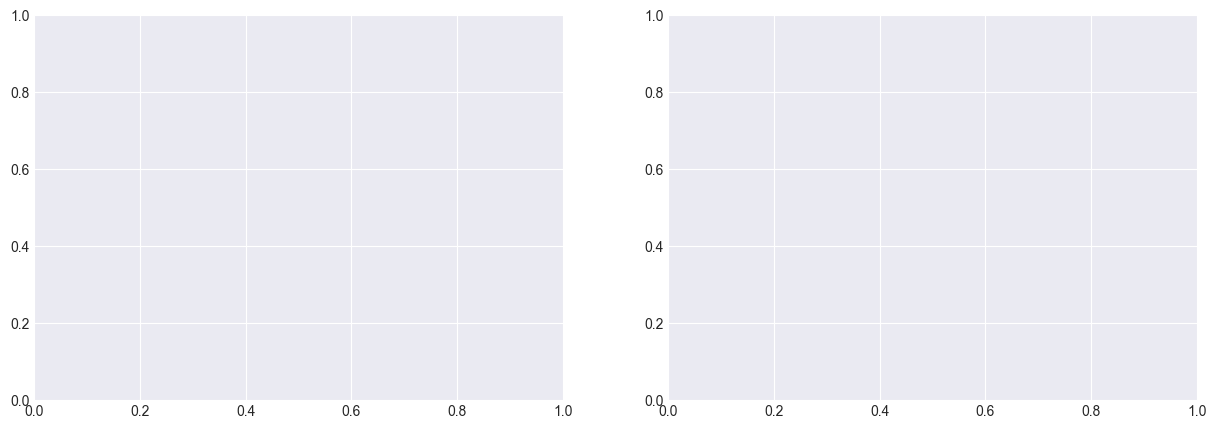

In [ ]:
# Visualize training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy Over Epochs', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Accuracy', fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss Over Epochs', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Loss', fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best results
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.4f} at Epoch {best_epoch}")

## 5. Model Evaluation

Comprehensive evaluation using multiple metrics: Accuracy, Precision, Recall, F1-Score, and Confusion Matrix.

In [42]:
# Evaluate on test set
print("📊 Evaluating model on test set...\n")

y_pred_probs = model.model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("="*60)
print("                    MODEL PERFORMANCE METRICS")
print("="*60)
print(f"  Test Accuracy:           {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Precision (Weighted):    {precision_weighted:.4f}")
print(f"  Recall (Weighted):       {recall_weighted:.4f}")
print(f"  F1-Score (Weighted):     {f1_weighted:.4f}")
print("="*60)

📊 Evaluating model on test set...

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 295ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 295ms/step
                    MODEL PERFORMANCE METRICS
  Test Accuracy:           0.7020 (70.20%)
  Precision (Weighted):    0.7672
  Recall (Weighted):       0.7020
  F1-Score (Weighted):     0.6927
                    MODEL PERFORMANCE METRICS
  Test Accuracy:           0.7020 (70.20%)
  Precision (Weighted):    0.7672
  Recall (Weighted):       0.7020
  F1-Score (Weighted):     0.6927


In [43]:
# Detailed classification report
print("\n📋 Detailed Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))


📋 Detailed Classification Report:

                  precision    recall  f1-score   support

 air_conditioner       0.59      0.86      0.70        28
        car_horn       0.90      0.82      0.86        11
children_playing       0.49      0.75      0.59        56
        dog_bark       1.00      0.48      0.65        27
        drilling       1.00      0.13      0.23        23
   engine_idling       0.81      0.73      0.77        71
        gun_shot       0.73      1.00      0.85        22
      jackhammer       0.92      0.93      0.92        71
           siren       0.42      0.71      0.53        24
    street_music       0.81      0.48      0.60        63

        accuracy                           0.70       396
       macro avg       0.77      0.69      0.67       396
    weighted avg       0.77      0.70      0.69       396



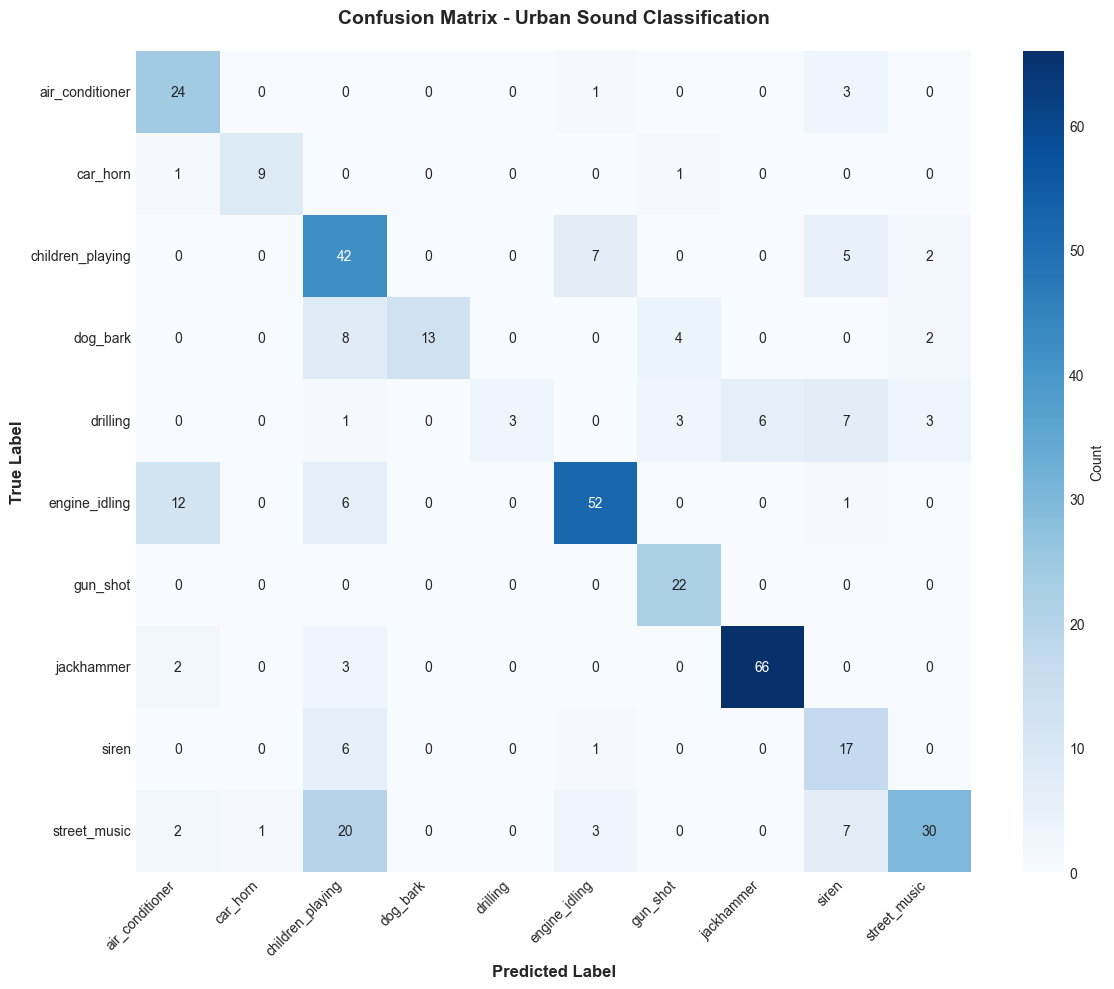


🎯 Per-Class Accuracy:
  air_conditioner     : 0.8571 (85.71%)
  car_horn            : 0.8182 (81.82%)
  children_playing    : 0.7500 (75.00%)
  dog_bark            : 0.4815 (48.15%)
  drilling            : 0.1304 (13.04%)
  engine_idling       : 0.7324 (73.24%)
  gun_shot            : 1.0000 (100.00%)
  jackhammer          : 0.9296 (92.96%)
  siren               : 0.7083 (70.83%)
  street_music        : 0.4762 (47.62%)


In [44]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Urban Sound Classification', fontweight='bold', fontsize=14, pad=20)
plt.xlabel('Predicted Label', fontweight='bold', fontsize=12)
plt.ylabel('True Label', fontweight='bold', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
print("\n🎯 Per-Class Accuracy:")
class_accuracies = cm.diagonal() / cm.sum(axis=1)
for i, (class_name, acc) in enumerate(zip(class_names, class_accuracies)):
    print(f"  {class_name:20s}: {acc:.4f} ({acc*100:.2f}%)")

## 6. Save the Trained Model

Save the model for deployment in FastAPI and Streamlit applications.

In [45]:
# Save the model
model_path = os.path.join(MODEL_DIR, "urbansound_cnn.keras")
model.save_model(model_path)

print(f"✅ Model saved successfully to: {model_path}")
print(f"📦 Model size: {os.path.getsize(model_path) / (1024*1024):.2f} MB")

# Also save class names for inference
class_names_path = os.path.join(MODEL_DIR, "class_names.json")
with open(class_names_path, 'w') as f:
    json.dump(class_names, f)
    
print(f"✅ Class names saved to: {class_names_path}")

Model saved to ../models\urbansound_cnn.keras
✅ Model saved successfully to: ../models\urbansound_cnn.keras
📦 Model size: 126.12 MB
✅ Class names saved to: ../models\class_names.json


In [48]:
# Save additional formats for API compatibility
print("\n📦 Saving model in additional formats for API compatibility...")

# Save in .h5 format for backward compatibility
try:
    h5_model_path = os.path.join(MODEL_DIR, "best_model.h5")
    model.model.save(h5_model_path)
    print(f"✅ Model also saved in .h5 format: {h5_model_path}")
    print(f"   Size: {os.path.getsize(h5_model_path) / (1024*1024):.2f} MB")
except Exception as e:
    print(f"⚠️ Could not save .h5 format: {e}")

# Save class names in txt format for backward compatibility
class_names_txt_path = os.path.join(PROCESSED_DIR, "class_names.txt")
with open(class_names_txt_path, 'w') as f:
    f.write('\n'.join(class_names))
print(f"✅ Class names also saved in txt format: {class_names_txt_path}")

print("\n✨ All model formats saved successfully!")
print(f"   Primary model (.keras): models/urbansound_cnn.keras")
print(f"   Compatible model (.h5): models/best_model.h5")
print(f"   Class names (JSON): models/class_names.json")
print(f"   Class names (TXT): data/processed/class_names.txt")


📦 Saving model in additional formats for API compatibility...
✅ Model also saved in .h5 format: ../models\best_model.h5
   Size: 126.13 MB
✅ Class names also saved in txt format: ../data/processed\class_names.txt

✨ All model formats saved successfully!
   Primary model (.keras): models/urbansound_cnn.keras
   Compatible model (.h5): models/best_model.h5
   Class names (JSON): models/class_names.json
   Class names (TXT): data/processed/class_names.txt
✅ Model also saved in .h5 format: ../models\best_model.h5
   Size: 126.13 MB
✅ Class names also saved in txt format: ../data/processed\class_names.txt

✨ All model formats saved successfully!
   Primary model (.keras): models/urbansound_cnn.keras
   Compatible model (.h5): models/best_model.h5
   Class names (JSON): models/class_names.json
   Class names (TXT): data/processed/class_names.txt


## 7. Test Predictions on Sample Audio

Let's test the model with some sample predictions to verify it's working correctly.

In [46]:
# Test predictions on random samples from test set
num_samples = 5
random_indices = random.sample(range(len(X_test)), num_samples)

print("🎯 Sample Predictions:\n")
print("="*80)

for idx in random_indices:
    sample = X_test[idx:idx+1]
    true_label = class_names[y_test[idx]]
    
    # Predict
    pred_probs = model.model.predict(sample, verbose=0)
    pred_class = np.argmax(pred_probs[0])
    pred_label = class_names[pred_class]
    confidence = pred_probs[0][pred_class] * 100
    
    # Determine if correct
    status = "✅ CORRECT" if pred_class == y_test[idx] else "❌ INCORRECT"
    
    print(f"Sample {idx:4d}: True={true_label:20s} | Predicted={pred_label:20s} | Confidence={confidence:5.2f}% {status}")

print("="*80)

🎯 Sample Predictions:

Sample   22: True=air_conditioner      | Predicted=air_conditioner      | Confidence=50.29% ✅ CORRECT
Sample  373: True=street_music         | Predicted=street_music         | Confidence=99.97% ✅ CORRECT
Sample  235: True=gun_shot             | Predicted=gun_shot             | Confidence=100.00% ✅ CORRECT
Sample  274: True=jackhammer           | Predicted=jackhammer           | Confidence=99.98% ✅ CORRECT
Sample  373: True=street_music         | Predicted=street_music         | Confidence=99.97% ✅ CORRECT
Sample  235: True=gun_shot             | Predicted=gun_shot             | Confidence=100.00% ✅ CORRECT
Sample  274: True=jackhammer           | Predicted=jackhammer           | Confidence=99.98% ✅ CORRECT
Sample   63: True=children_playing     | Predicted=children_playing     | Confidence=99.84% ✅ CORRECT
Sample   63: True=children_playing     | Predicted=children_playing     | Confidence=99.84% ✅ CORRECT
